In [1]:
# Se importan las librerias necesarias para el desarrollo del proyecto
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Configuración de estilo para las gráficas
sns.set_style('darkgrid')
plt.style.use('ggplot')

In [2]:
# Se cargan el dataset en una estructura de datos dataframe 
df = pd.read_csv('./data/creditcard.csv', sep=',', dtype={'Class': 'str'})

# Se ajusta el tipo de dato de la columna 'Class' a numérico
df['Class'] = pd.to_numeric(df['Class'].str.strip("'"))

# Se visualiza la información del dataset
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Se crea una copia del dataset para no modificar el original
df1 = df.copy()

# Se eliminan las columnas 'Time' y 'Amount' para hacer la detección de registros duplicados
df1= df1.drop(['Time','Amount','Class'], axis=1)
print("\nRegistros duplicados:", df1.duplicated().sum())

# Se hace resumen estadístico de todas las columnas del dataset original
print("\nResumen estadístico:")
df.describe()


Registros duplicados: 9144

Resumen estadístico:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Distribución de Variables

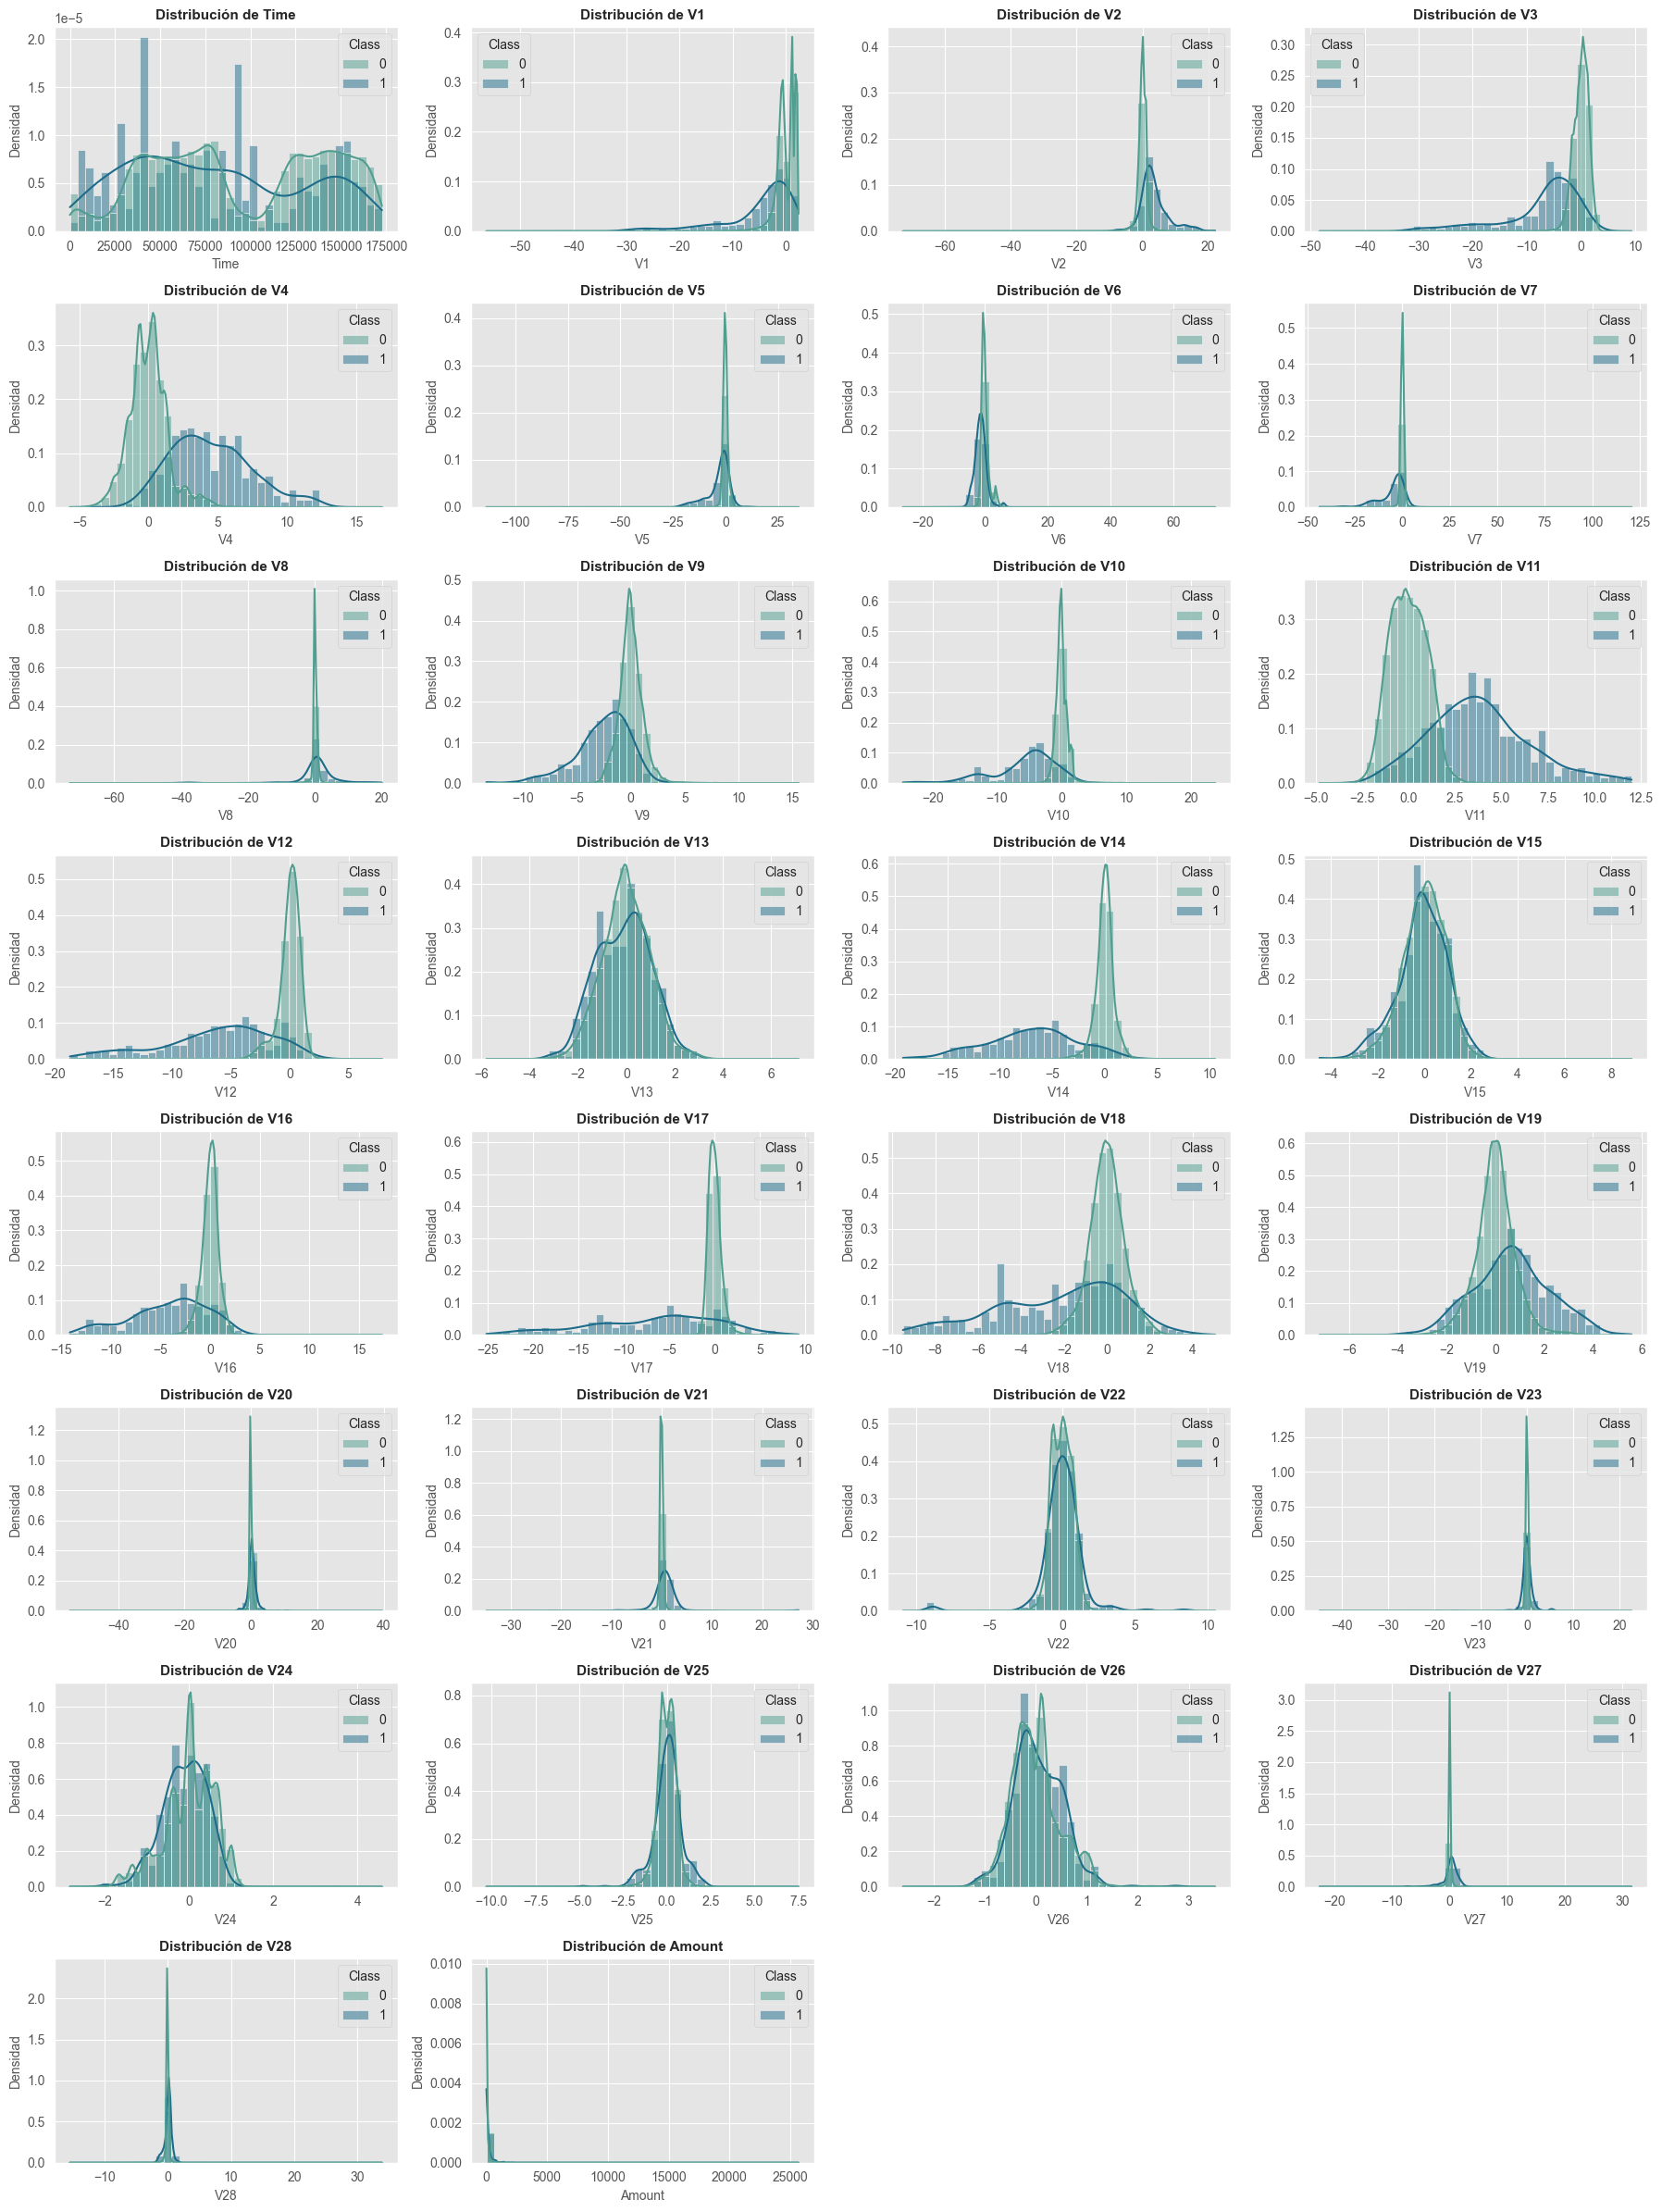

In [4]:
# Se visualiza la densidad de probabilidad de cada variable agrupadas por la clase ('Class', 0: Transacción Legítima, 1: Transacción Fraudulenta)
plt.figure(figsize=(18, 24))

for i, column in enumerate(df.columns[:30], 1):
    plt.subplot(8, 4, i)
    ax = sns.histplot(df, x=column, bins=40, kde=True, hue='Class',  element='bars', stat="density", common_norm=False, palette='crest')

    plt.title(f'Distribución de {column}', fontsize=11, fontweight='bold')
    plt.xlabel(column, fontsize=10)
    plt.ylabel('Densidad', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

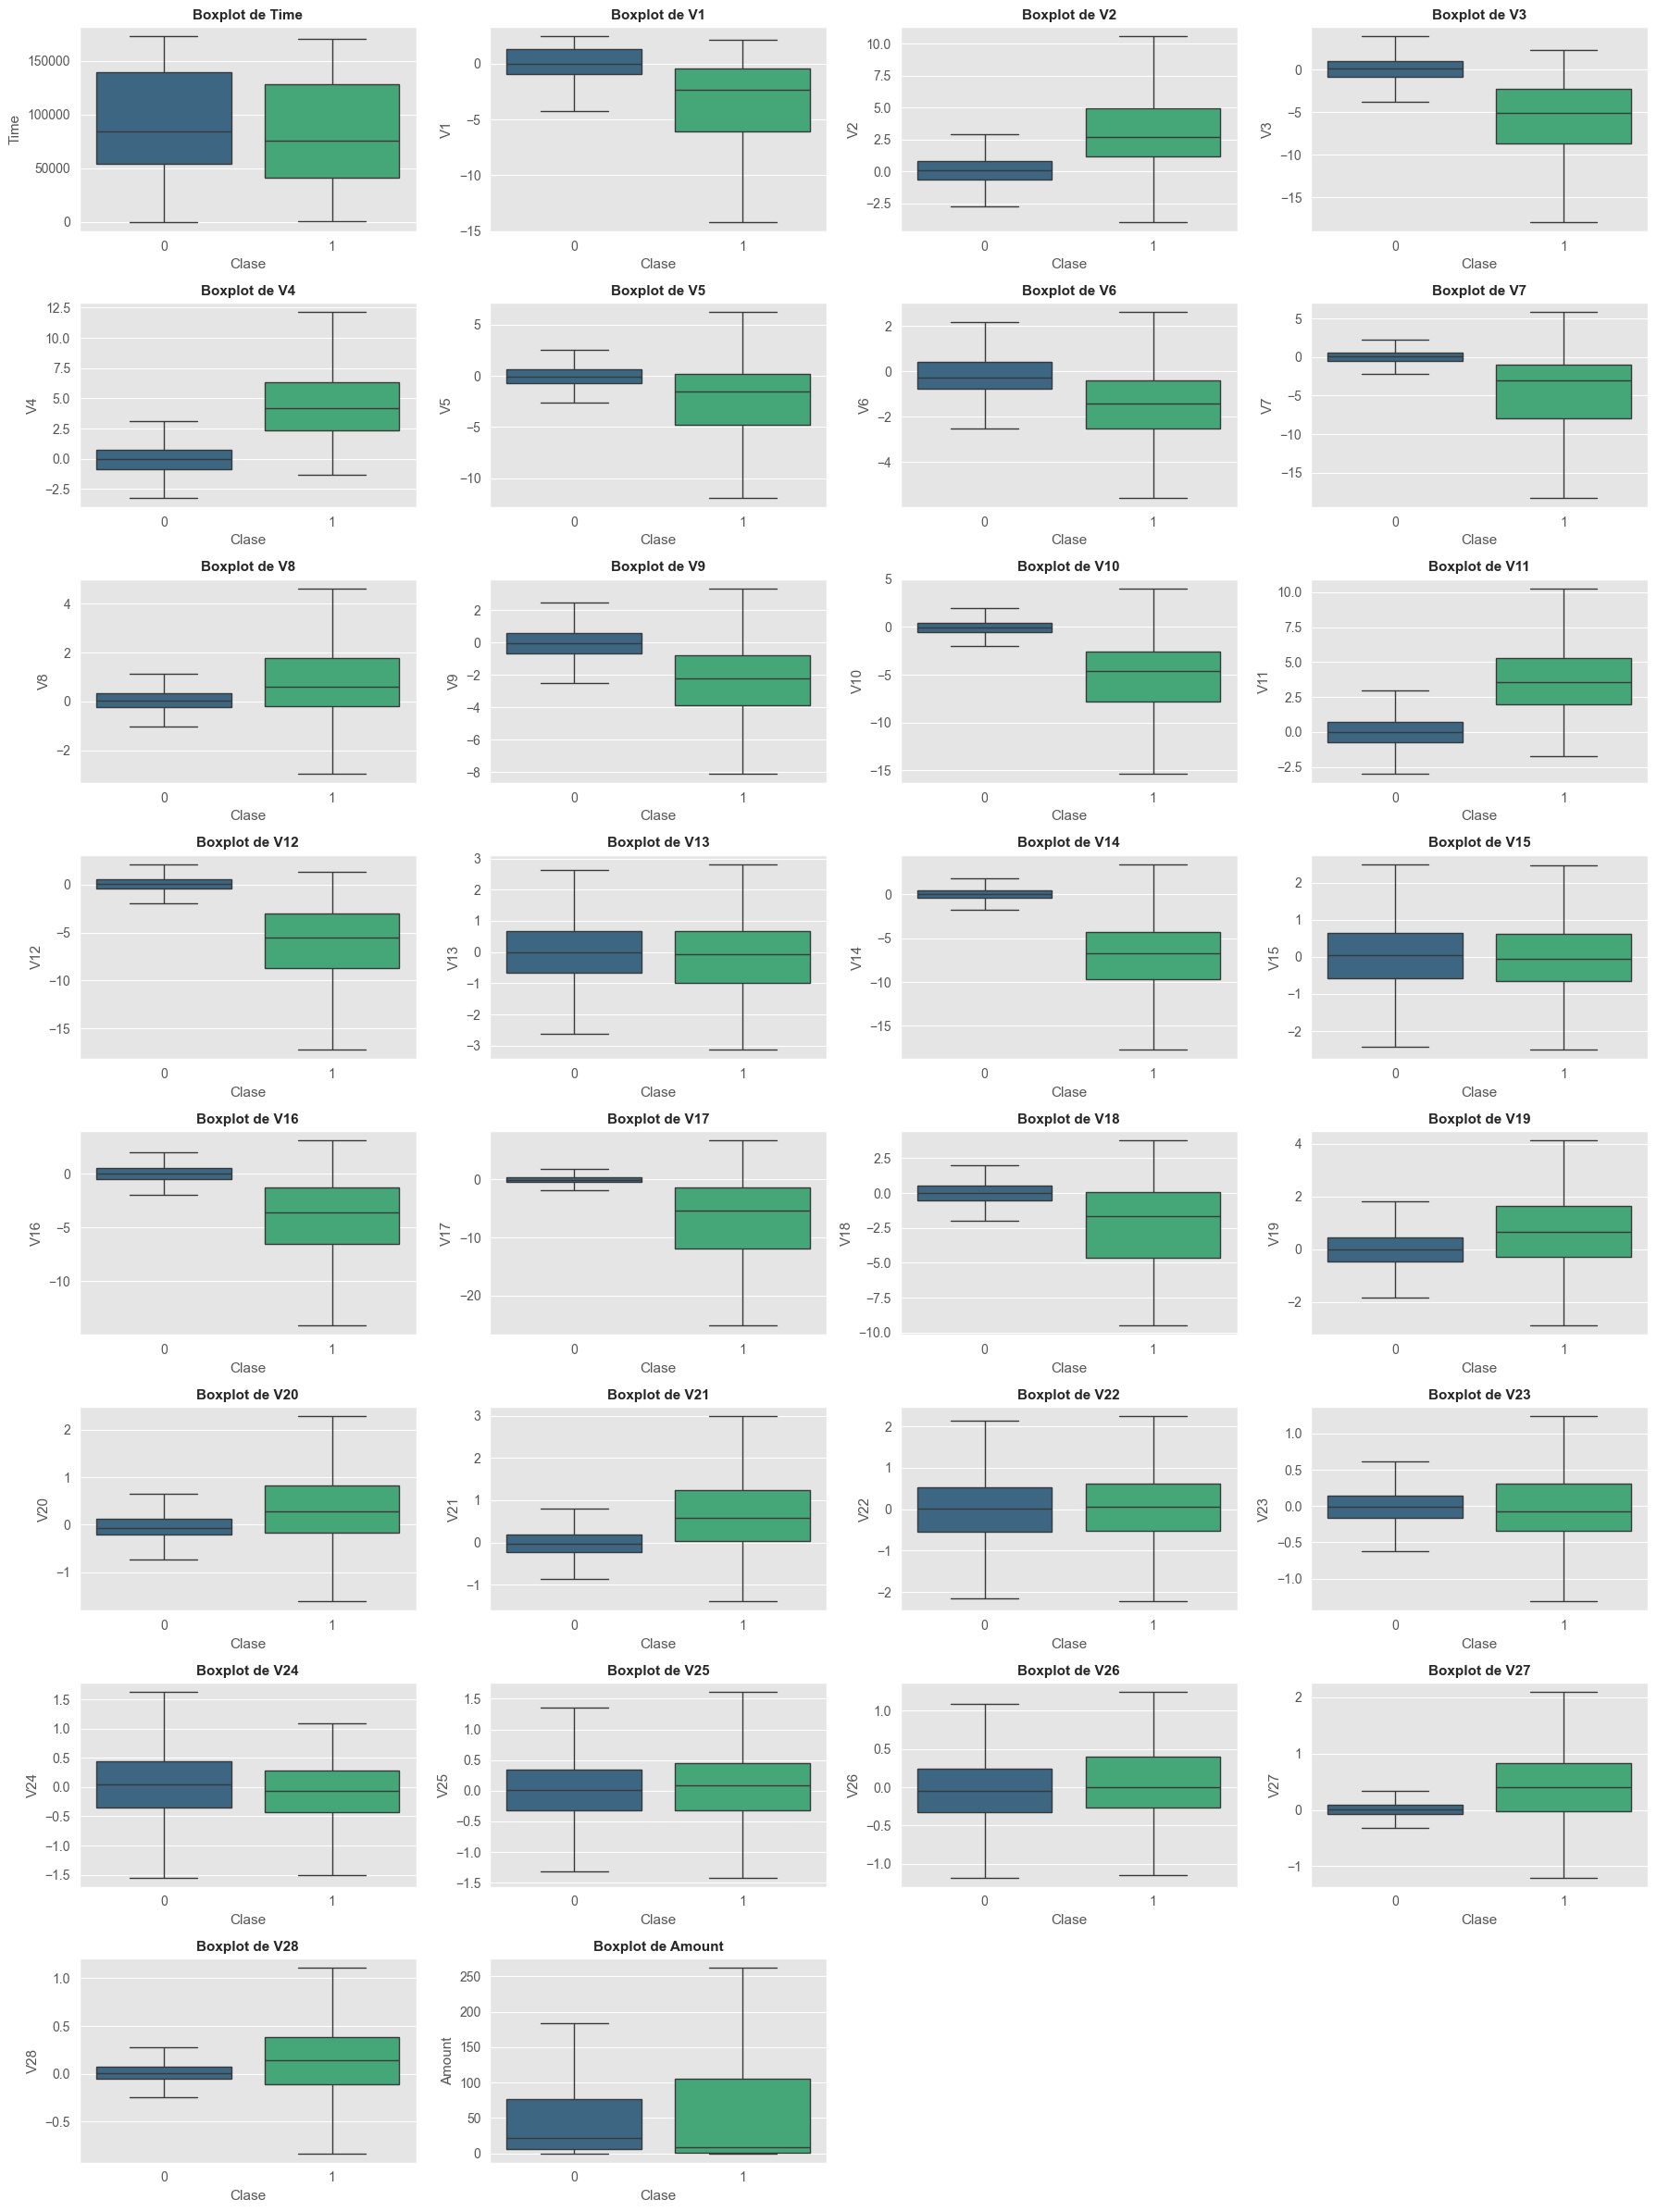

In [5]:
# Se visualiza por medio de Boxplots la distribución de cada variable agrupadas por la clase ('Class', 0: Transacción Legítima, 1: Transacción Fraudulenta)
plt.figure(figsize=(18, 24)) 

for i, column in enumerate(df.columns[:30], 1):
    plt.subplot(8, 4, i)
    sns.boxplot(x='Class', y=column, data=df, hue='Class', palette='viridis', showfliers=False, legend=False)
    plt.title(f'Boxplot de {column}', fontsize=11, fontweight='bold')
    plt.xlabel('Clase', fontsize=11)
    plt.ylabel(column, fontsize=11)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

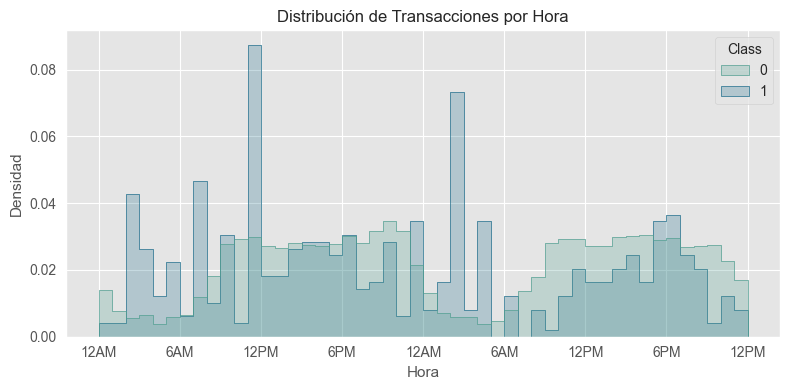

In [6]:
# Se visualiza la distribución de las transacciones por hora agrupadas por la clase ('Class', 0: Transacción Legítima, 1: Transacción Fraudulenta)
df['Time_in_hours'] = df['Time'] / 3600  
plt.figure(figsize=(8, 4)) 
sns.histplot(df, x='Time_in_hours', bins=48, element='step', stat="density", common_norm=False, hue='Class', palette='crest')
plt.title('Distribución de Transacciones por Hora', fontsize=12)
plt.xlabel('Hora', fontsize=11)
plt.ylabel('Densidad', fontsize=11)
ticks = [0, 6, 12, 18, 24, 30, 36, 42, 48]
labels = ['12AM', '6AM', '12PM', '6PM', '12AM','6AM', '12PM', '6PM', '12PM']
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [7]:
# Se determinan los montos totales de las transacciones agrupadas por la clase ('Class', 0: Transacción Legítima, 1: Transacción Fraudulenta) y su análisis estadístico
print(f"Suma de Transacciones: {df.groupby('Class')['Amount'].sum().map('{:,.2f}'.format):}")
amount_class = df.groupby('Class')['Amount'].describe()
amount_class 

Suma de Transacciones: Class
0    25,102,462.04
1        60,127.97
Name: Amount, dtype: object


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


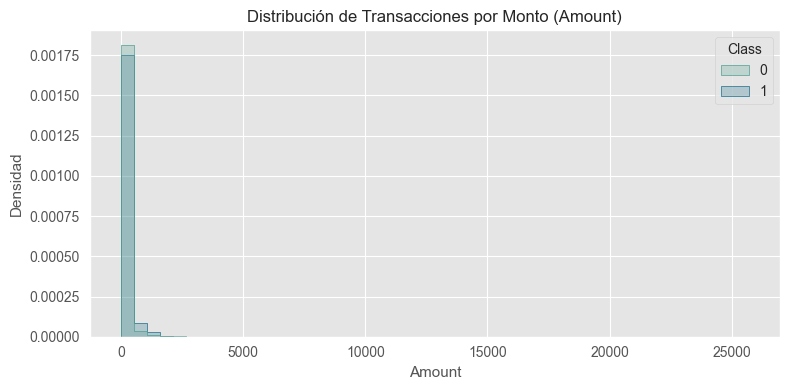

In [8]:
# Se visualiza la distribución del periódo entre transacciones agrupadas por la clase ('Class', 0: Transacción Legítima, 1: Transacción Fraudulenta)
plt.figure(figsize=(8, 4)) 
sns.histplot(df, x="Amount", bins=48, element="step", stat="density", common_norm=False, hue='Class', palette='crest')
plt.title('Distribución de Transacciones por Monto (Amount)', fontsize=12)
plt.xlabel('Amount', fontsize=11)
plt.ylabel('Densidad', fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [9]:
# Se crea una función apra formatear las horas en formato de 12 horas
def format_func(x, pos):
    hours = int(x)
    return (datetime.min + timedelta(hours=hours)).strftime('%I %p')
df['Datetime'] = df['Time_in_hours'].apply(lambda x: format_func(x, 0))
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_in_hours,Datetime
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000,12 AM
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000,12 AM
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000278,12 AM
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000278,12 AM
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000556,12 AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,47.996111,11 PM
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,47.996389,11 PM
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,47.996667,11 PM
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,47.996667,11 PM


Análisis de la Variable Objetivo

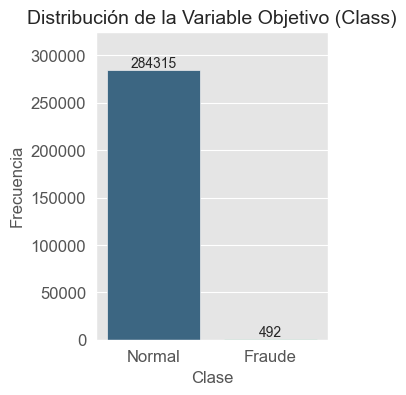

In [10]:
# Se crea el gráfico de barras
plt.figure(figsize=(3, 4))
ax = sns.countplot(x='Class', data=df, palette='viridis',hue='Class', dodge=False,legend=False)

# Se obtienen las frecuencias de cada clase
frequencies = df['Class'].value_counts()

# SE agregan los valores a cada barra
for i, (label, count) in enumerate(frequencies.items()):
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.title('Distribución de la Variable Objetivo (Class)', fontsize=14)
plt.ylim(0, 325000)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Normal', 'Fraude'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Valores duplicados en Clase 0 1062

Valores duplicados en Clase 1: 19


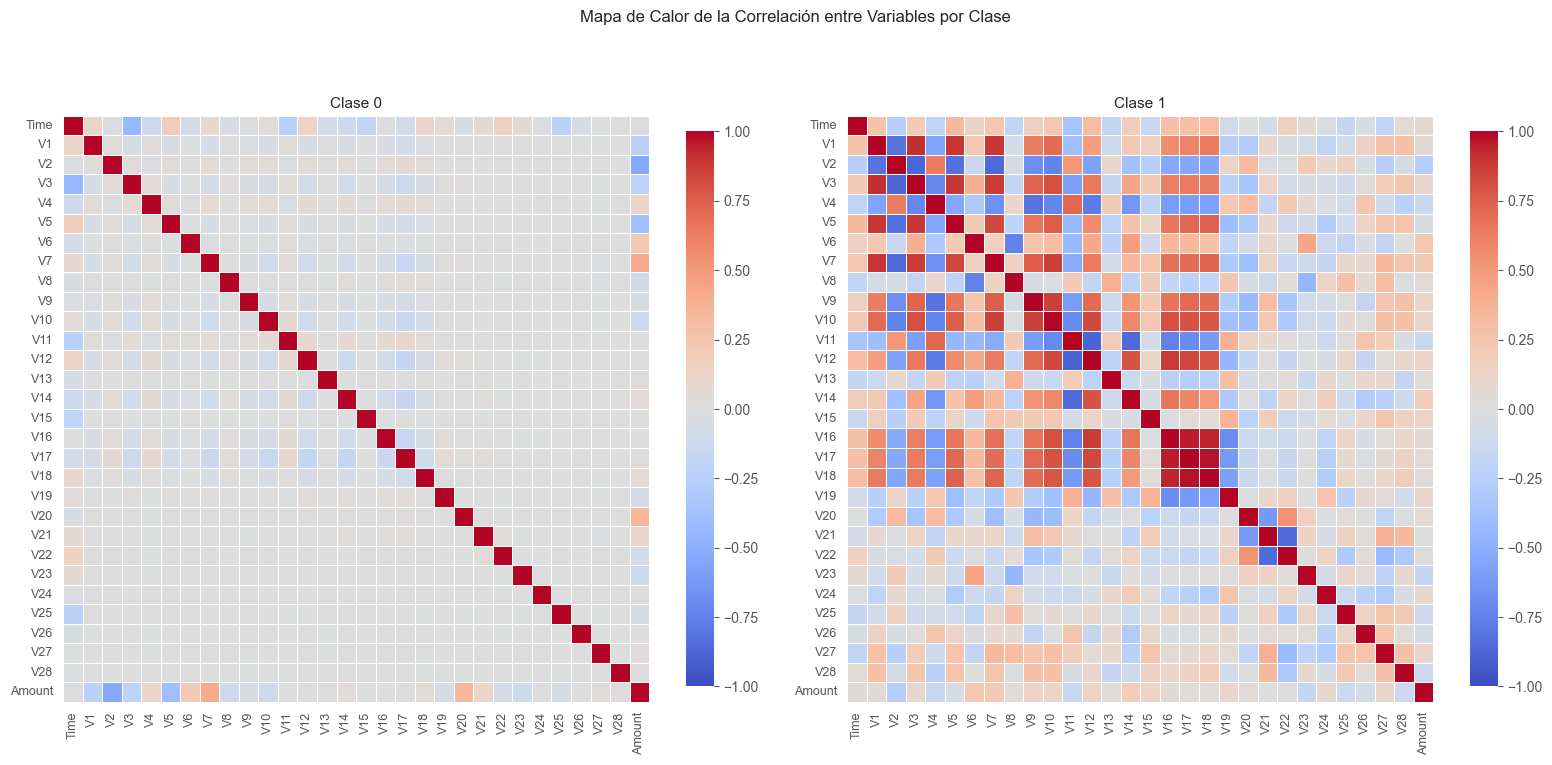

In [11]:
# Se calcula la matriz de correlación
df_0 = df[df['Class'] == 0].iloc[:,:30]
df_1 = df[df['Class'] == 1].iloc[:,:30]

# Se verifican si hay valores duplicados
print("\nValores duplicados en Clase 0", df_0.duplicated().sum())
print("\nValores duplicados en Clase 1:", df_1.duplicated().sum())

corr_matrix_0 = df_0.corr()
corr_matrix_1 = df_1.corr()

# Se visualiza la matriz de correlación
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16, 8)  
plt.subplots_adjust(wspace=0.2)
fig.suptitle('Mapa de Calor de la Correlación entre Variables por Clase', fontsize=12)

sns.heatmap(corr_matrix_0, annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True,
             cbar_kws={"shrink": .75}, annot_kws={"size": 8, "color": "black"},
             linecolor='white', vmin=-1, vmax=1, ax=axs[0])  # Corrección: Usar axs[0]

sns.heatmap(corr_matrix_1, annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True,
             cbar_kws={"shrink": .75}, annot_kws={"size": 8, "color": "black"},
             linecolor='white', vmin=-1, vmax=1, ax=axs[1])  # Corrección: Usar axs[1]

axs[0].set_title('Clase 0',fontsize=11)
axs[1].set_title('Clase 1',fontsize=11)

axs[0].tick_params(axis='both', which='both', labelsize=9)
axs[1].tick_params(axis='both', which='both', labelsize=9)
plt.tight_layout()
plt.show()

In [12]:
# Se declara una función para realizar el test de Kolmogorov-Smirnov para dos variables
def ks_test(var1, var2, alpha=0.05):
    """
    Realiza el test de Kolmogorov-Smirnov para dos variables.
    
    Parameters:
    var1 (array): Variable 1
    var2 (array): Variable 2
    
    Returns:
    ks_statistic (float): Estadístico de la prueba
    p_value (float): Valor p
    """
    ks_statistic, p_value = stats.ks_2samp(var1, var2)

    if p_value < alpha:
        print("The two variables are significantly different.")
    else:
        print("There is not enough evidence to conclude that the variables are different.")

# Se realizan los test de Kolmogorov-Smirnov para las variables seleccionadas
vars = ["V13","V15","V22","V23","V24","V25","V26","V27","V28","Amount"]
for var in vars:
    print(f"\nVariable: {var}")
    ks_test(df_0[var], df_1[var], 0.01)   


Variable: V13
The two variables are significantly different.

Variable: V15
There is not enough evidence to conclude that the variables are different.

Variable: V22
There is not enough evidence to conclude that the variables are different.

Variable: V23
The two variables are significantly different.

Variable: V24
The two variables are significantly different.

Variable: V25
The two variables are significantly different.

Variable: V26
The two variables are significantly different.

Variable: V27
The two variables are significantly different.

Variable: V28
The two variables are significantly different.

Variable: Amount
The two variables are significantly different.


In [13]:
# Se separan las variables predictoras y la variable objetivo
X = df.drop(['Class'], axis=1)
y_feature = df['Class']

# Se hace un encoding de la variable 'Datetime' y se estandarizan las variables predictoras
le = LabelEncoder()
X['Datetime'] = le.fit_transform(X['Datetime'])
X_1 = X.drop(columns=['Datetime','Time_in_hours'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_1)

# Se crea un dataframe con las variables predictoras estandarizadas
X_feature = pd.DataFrame(X_scaled, columns=X_1.columns)
X_feature = pd.concat([X_feature, X['Datetime']], axis=1)

In [14]:
# Se entrena el modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42, n_jobs=-1)
rf.fit(X_feature, y_feature)

# Se obtienen las importancias de las variables
rf_importances = rf.feature_importances_
rf_importances = pd.Series(rf_importances, index=X_feature.columns).sort_values(ascending=False).reset_index()

# SE entrena el modelo XGBoost
xgb = XGBClassifier(scale_pos_weight=sum(y_feature == 0) / sum(y_feature == 1),random_state=42, n_jobs=-1, eval_metric='logloss') 
xgb.fit(X_feature, y_feature)

# Se obtienen las importancias de las variables
xgb_importances = xgb.feature_importances_
xgb_importances = pd.Series(xgb_importances, index=X_feature.columns).sort_values(ascending=False).reset_index()

# Se comparan las importancias de las variables en un dataframe
comparision = pd.concat([rf_importances, xgb_importances], axis=1)
comparision.columns = ['Var_rf','Random Forest','Var_xgb','XGBoost']
comparision

,Var_rf,Random Forest,Var_xgb,XGBoost
0,V14,0.202918,V14,0.575139
1,V10,0.138412,V4,0.066500
2,V12,0.097837,V12,0.036910
3,V4,0.088832,V8,0.034249
4,V11,0.077571,V20,0.024950
5,V17,0.063415,V6,0.016907
6,V3,0.045047,V27,0.015979
7,V16,0.036603,V10,0.015238
8,V7,0.030287,V7,0.014869
9,V9,0.022753,V18,0.014184


In [15]:
# Se crea un diccionario con las importancias de las variables
rf_dict = dict(zip(comparision['Var_rf'], comparision['Random Forest']))
xgb_dict = dict(zip(comparision['Var_xgb'], comparision['XGBoost']))

# Se combinan las variables de ambos modelos
all_vars = set(comparision['Var_rf']).union(set(comparision['Var_xgb']))

# Se calculan los promedios de las importancias de las variables
averages = {}
for var in all_vars:
    rf_value = rf_dict.get(var, 0)  # Use 0 if not present, assuming full data would have all variables
    xgb_value = xgb_dict.get(var, 0)
    avg = (rf_value + xgb_value) / 2
    averages[var] = avg

# Se crea un dataframe con los promedios de las importancias de las variables
result_df = pd.DataFrame(list(averages.items()), columns=['Variable', 'Average Importance'])
result_df = result_df.sort_values('Average Importance', ascending=False).reset_index(drop=True)
result_df

,Variable,Average Importance
0,V14,0.389029
1,V4,0.077666
2,V10,0.076825
3,V12,0.067374
4,V11,0.043243
5,V17,0.037924
6,V3,0.026306
7,V8,0.023235
8,V7,0.022578
9,V16,0.020906


In [16]:
# Se determinan el número de variables a considerar para el modelo basado en el promedio de las importancias
num_var = 19
print(result_df['Average Importance'][:num_var].sum())
var_to_keep = sorted(result_df['Variable'][:num_var].tolist())

0.9094658577312339


In [17]:
# Se determinan el número de variables a considerar para el modelo basado en las importancias del modelo Random Forest
num_var = 17
print(rf_importances.iloc[:num_var].sum())
var_to_keep = sorted(rf_importances['index'][:num_var].tolist())

index    V14V10V12V4V11V17V3V16V7V9V2V21V18V19V8AmountV20
0                                                0.907637
dtype: object


In [18]:
# Se determinan el número de variables a considerar para el modelo basado en las importancias del modelo XGBoost
num_var = 17
print(xgb_importances.iloc[:num_var].sum())
var_to_keep = sorted(xgb_importances['index'][:num_var].tolist())

index    V14V4V12V8V20V6V27V10V7V18V23V2V26V28V17V13V19
0                                              0.903096
dtype: object


In [19]:
# Se crea el dataset con las variables seleccionadas
df_model = df[var_to_keep + ['Class']]
df_model

,V10,V12,V13,V14,V17,V18,V19,V2,V20,V23,V26,V27,V28,V4,V6,V7,V8,Class
0,0.090794,-0.617801,-0.991390,-0.311169,0.207971,0.025791,0.403993,-0.072781,0.251412,-0.110474,-0.189115,0.133558,-0.021053,1.378155,0.462388,0.239599,0.098698,0
1,-0.166974,1.065235,0.489095,-0.143772,-0.114805,-0.183361,-0.145783,0.266151,-0.069083,0.101288,0.125895,-0.008983,0.014724,0.448154,-0.082361,-0.078803,0.085102,0
2,0.207643,0.066084,0.717293,-0.165946,1.109969,-0.121359,-2.261857,-1.340163,0.524980,0.909412,-0.139097,-0.055353,-0.059752,0.379780,1.800499,0.791461,0.247676,0
3,-0.054952,0.178228,0.507757,-0.287924,-0.684093,1.965775,-1.232622,-0.185226,-0.208038,-0.190321,-0.221929,0.062723,0.061458,-0.863291,1.247203,0.237609,0.377436,0
4,0.753074,0.538196,1.345852,-1.119670,-0.237033,-0.038195,0.803487,0.877737,0.408542,-0.137458,0.502292,0.219422,0.215153,0.403034,0.095921,0.592941,-0.270533,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,4.356170,2.711941,-0.689256,4.626942,1.991691,0.510632,-0.682920,10.071785,1.475829,1.014480,0.250034,0.943651,0.823731,-2.066656,-2.606837,-4.918215,7.305334,0
284803,-0.975926,0.915802,1.214756,-0.675143,-0.025693,-1.221179,-1.545556,-0.055080,0.059616,0.012463,-0.395255,0.068472,-0.053527,-0.738589,1.058415,0.024330,0.294869,0
284804,-0.484782,0.063119,-0.183699,-0.510602,0.313502,0.395652,-0.577252,-0.301254,0.001396,-0.037501,-0.087371,0.004455,-0.026561,-0.557828,3.031260,-0.296827,0.708417,0
284805,-0.399126,-0.962886,-1.042082,0.449624,0.509928,1.113981,2.897849,0.530483,0.127434,-0.163298,0.546668,0.108821,0.104533,0.689799,0.623708,-0.686180,0.679145,0


In [20]:
# Se guarda en nuevo dataset con las variables seleccionadas en formato CSV
df_model.to_csv('./data/creditcard_model.csv', index=False)